<a href="https://colab.research.google.com/github/ShengpeiWang/kick-with-bert/blob/master/Kick_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Compare RoBERTa model with traditional ML approach.

The results using the RoBERTa model can be found in the "kick_roberta_fastai2.ipynb." Since I used a classification head rather than a regression head, the results aren't directly comparable with my previous attempts using traditional ML approach (ridge regression). Here I will perform the classification tast using ML approaches to better understand the performance of the RoBERTa model. 

In [28]:
# set up other dependencies
# for data input and output
from google.colab import drive
import pickle
import pandas as pd
import numpy as np

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt

# NLP preprocessing functions
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

# train test split
from sklearn.model_selection import train_test_split

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
from scipy.sparse import hstack

# modeling functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import ElasticNet, Lasso # sparse models
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge # regularization properties
from sklearn.kernel_ridge import KernelRidge #

# model testing
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve

In [3]:
# local drive set up, so I can access data in Googel drive 
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/kick'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Load and process data

In [4]:
# load the data:
with open(base_dir + "/project_data_complete.pkl", "rb") as f:
  df = pickle.load(f)

In [5]:
df.shape

(2107, 30)

In [6]:
df['story_tb'] = df["project_name"].map(str) + df["blurb"].map(str) +df["story"].map(str)

In [7]:
df.columns = ['index', 'project_id_1', 'url', 'story', 'project_id', 'project_name',
       'blurb', 'goal', 'pledge', 'state', 'country', 'deadline', 'create',
       'launch', 'staff_pick', 'backers', 'usd_rate', 'creator', 'category',
       'url', 'category_name', 'category_parent', 'name_parent', 'goal_usd',
       'pledge_usd', 'percent', 'days_active', 'days_draft', 'language',
       'keep_story', 'story_tb']

In [8]:
# word count and length in title and blurb
df['title_words'] = df['project_name'].str.split().str.len()
df['title_l'] = df['project_name'].str.len()
df['blurb_words'] = df['blurb'].str.split().str.len()
df['blurb_l'] = df['blurb'].str.len()

In [9]:
df['l_goal'] = np.log10(df['goal_usd'] + 1)
df['l_pledge'] = np.log10(df['pledge_usd'] + 1)
df['l_percent'] = np.log10(df['percent']*100+1)
max_bin = max(df['percent']*100)+1
df['performance'] = pd.cut(df['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = ["fail", "some", "goal", "great"],
                                 right = False)
df['performance_n'] = pd.cut(df['percent']*100,
                                 bins = [0, 1, 100, 120, max_bin], 
                                 labels = [0,1,2,3],
                                 right = False)
df['performance_s'] = round(df['l_pledge'])

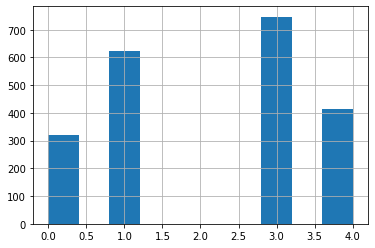

In [63]:
df['performance_s'] = pd.cut(df['l_pledge'],
                                 bins = [0, 1, 3, 4, 7], 
                                 labels = [0,1,3,4],
                                 right = False)
df['performance_s'].hist()
# The bins aren't totally even

## NLP processing

In [11]:
# define function to lemmatize long-form text
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def lemmatizer(sentence):
    token_words = word_tokenize(sentence)
    lem_sentence=[]
    for word in token_words:
        lemma = wnl.lemmatize(word)
        lem_sentence.append(lemma)
        lem_sentence.append(" ")
    return "".join(lem_sentence)

# make preprocessing pipeline:
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

def preproc(text):
    l = re.sub(r'http\S+',' ', text) # remove links
    n = re.sub(r'[0-9]+', ' ', l) # remove numbers
    s = re.sub(r'[^\w]',' ', n)  # remove symbols
    w = pattern.sub('', s) # remove stopwords
    p = lemmatizer(w) # lemmatize all words
    return p

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [12]:
# combine the apply the preprocessing pipeline to all available data
df['story_p'] = df.apply(lambda x: preproc(x['story_tb']), axis=1)
# add total text length
df['total_words'] = df['story_p'].str.split().str.len()

In [13]:
with open(base_dir + "/project_data_ml.pkl", "wb") as f:
  pickle.dump(df, f)

## Modeling

In [14]:
# make function to display r2 and mse easily:
def display_score(y_true, y_predict):
    print("r2:",round(r2_score(y_true,y_predict), 3),
          "mse:",round(mean_squared_error(y_true,y_predict), 3))

In [64]:
data_project_c = df.sample(frac=1, random_state = 89).reset_index(drop=True)
data_y = data_project_c[['performance', 'performance_n', 'l_pledge', 'performance_s']]
data_x = data_project_c[['name_parent', 'goal_usd', 'story_p', 'title_l', 'total_words']]
# name_parent is the name of the main category

X_train, X_test, Y_train, Y_test = train_test_split(data_x, data_y, test_size = 0.20, random_state = 61, stratify = data_x[['name_parent']])

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.20, random_state = 59, stratify = X_train[['name_parent']])

In [16]:
tfidf = TfidfVectorizer(max_features = 1500)
# note the default normalizes the output matrix
tfidf_m = tfidf.fit_transform(x_train['story_p'])
tfidf_val = tfidf.transform(x_val['story_p'])

tfidf_m.shape

(1348, 1500)

In [17]:
# add category information
encoder = onehot.fit_transform(x_train[['name_parent']])
encoded_val = onehot.transform(x_val[['name_parent']])

# combine different feature data
x_train_info = x_train[['goal_usd', 'title_l', 'total_words']]
x_train_sparse = hstack([tfidf_m, encoder]).toarray()
x_train_full = np.concatenate((x_train_info, x_train_sparse), axis= 1)

x_val_info = x_val[['goal_usd', 'title_l', 'total_words']]
x_val_sparse = hstack([tfidf_val, encoded_val]).toarray()
x_val_full = np.concatenate((x_val_info, x_val_sparse), axis= 1)

In [18]:
x_train_info = x_train[['title_l', 'total_words']]
x_train_sparse_r = hstack([tfidf_m, encoder]).toarray()
x_train_full_r = np.concatenate((x_train_sparse, x_train_info), axis= 1)

x_val_info = x_val[['title_l', 'total_words']]
x_val_sparse_r = hstack([tfidf_val, encoded_val]).toarray()
x_val_full_r = np.concatenate((x_val_sparse, x_val_info), axis= 1)

ridge_r = Ridge()
ridge_r.fit(x_train_full_r, y_train['l_pledge'])
ridge_r_predict = ridge_r.predict(x_val_full_r)
display_score(y_val['l_pledge'], ridge_r_predict)

r2: 0.267 mse: 1.327


In [19]:
for i in range(0, 11):
  alpha = i/10
  ridge_r = Ridge(alpha = alpha)
  ridge_r.fit(x_train_full_r, y_train['l_pledge'])
  ridge_r_predict = ridge_r.predict(x_val_full_r)
  print(f"alpha = {alpha}"), display_score(y_val['l_pledge'], ridge_r_predict)

# The model performed as did previously

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


alpha = 0.0
r2: -3.386 mse: 7.94
alpha = 0.1
r2: -0.116 mse: 2.02
alpha = 0.2
r2: 0.056 mse: 1.708
alpha = 0.3
r2: 0.132 mse: 1.572
alpha = 0.4
r2: 0.175 mse: 1.493
alpha = 0.5
r2: 0.203 mse: 1.442
alpha = 0.6
r2: 0.224 mse: 1.405
alpha = 0.7
r2: 0.239 mse: 1.378
alpha = 0.8
r2: 0.25 mse: 1.357
alpha = 0.9
r2: 0.259 mse: 1.34
alpha = 1.0
r2: 0.267 mse: 1.327


## Classification


In [20]:
# to establish a baseline with random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(x_train_full_r, y_train['performance_s'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
rf_predict = rf.predict(x_val_full_r)

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val['performance_s'], rf_predict)

0.5103857566765578

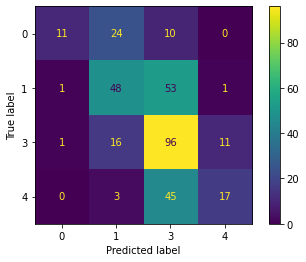

In [36]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(rf, x_val_full_r, y_val['performance_s'])

In [38]:
# to establish a baseline with random forest using only language features
rf.fit(tfidf_m, y_train['performance_s'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
rf_predict = rf.predict(tfidf_val)
accuracy_score(y_val['performance_s'], rf_predict)
# Actually a random forest performs better than the deep learning approach

0.5044510385756676

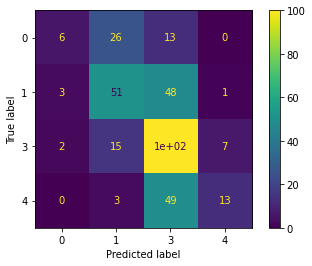

In [41]:
plot_confusion_matrix(rf, tfidf_val, y_val['performance_s'])

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
gb.fit(x_train_full_r, y_train['performance_s'])

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [68]:
accuracy_score(y_val['performance_s'], gb.predict(x_val_full_r))

0.45103857566765576

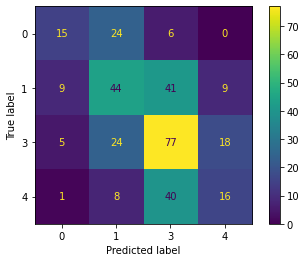

In [70]:
plot_confusion_matrix(gb, x_val_full_r, y_val['performance_s'])
# Gradient boosting performs worse than random forest

In [71]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_full_r, y_train['performance_s'])
accuracy_score(y_val['performance_s'], lr.predict(x_val_full_r))
# Logistic regression also doesn't perform as well

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.4658753709198813

## Improve random forest performance with hyperparameter tuning

In [86]:
for i in range(0, 50, 5):
  rf = RandomForestClassifier(criterion = 'entropy', min_samples_split = i+2)
  rf.fit(tfidf_m, y_train['performance_s'])
  print(i+2, accuracy_score(y_val['performance_s'], rf.predict(tfidf_val)))
# the best parameter is about 22

2 0.4836795252225519
7 0.49258160237388726
12 0.5014836795252225
17 0.49258160237388726
22 0.5103857566765578
27 0.5014836795252225
32 0.486646884272997
37 0.49258160237388726
42 0.4896142433234421
47 0.4896142433234421


In [88]:
for i in range(50, 100, 10):
  rf = RandomForestClassifier(criterion = 'entropy', min_samples_split = 22, max_samples = i/100)
  rf.fit(tfidf_m, y_train['performance_s'])
  print(i/100, accuracy_score(y_val['performance_s'], rf.predict(tfidf_val)))

0.5 0.486646884272997
0.6 0.49258160237388726
0.7 0.4836795252225519
0.8 0.47477744807121663
0.9 0.49258160237388726


In [98]:
rf = RandomForestClassifier(criterion = 'entropy', min_samples_split = 22, class_weight = 'balanced')
rf.fit(tfidf_m, y_train['performance_s'])
accuracy_score(y_val['performance_s'], rf.predict(tfidf_val))
# balanced class weight tend to reduce model performance

0.47774480712166173

In [99]:
for i in range(10, 100, 10):
  rf = RandomForestClassifier(criterion = 'entropy', max_depth = i, min_samples_split = 22)
  rf.fit(tfidf_m, y_train['performance_s'])
  print(i, accuracy_score(y_val['performance_s'], rf.predict(tfidf_val)))

10 0.4836795252225519
20 0.49258160237388726
30 0.49554896142433236
40 0.47477744807121663
50 0.49258160237388726
60 0.4807121661721068
70 0.49554896142433236
80 0.4896142433234421
90 0.5222551928783383


In [100]:
for i in range(100, 160, 10):
  rf = RandomForestClassifier(criterion = 'entropy', max_depth = i, min_samples_split = 22)
  rf.fit(tfidf_m, y_train['performance_s'])
  print(i, accuracy_score(y_val['performance_s'], rf.predict(tfidf_val)))

100 0.5074183976261127
110 0.49554896142433236
120 0.4807121661721068
130 0.49258160237388726
140 0.49258160237388726
150 0.49554896142433236


## The model can predict the correct class 52% of the time.
This simple (random forest) approach ended up performing better than other classification models (logistic regression, gradient boost). It also performed better than the more complex approaching using transfer learning with the base RoBERTa model. 

Even though the model is twice as accurate than a random predecition (52% vs 25% in the case of four classes), it still suffers from a lack of data. Which I will tackle in the future